In [1]:
import tensorflow as tf
import numpy as np
import wfdb
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import signal
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method


In [2]:
#!/usr/bin/env python

# Do *not* edit this script.
# These are helper functions that you can use with your code.
# Check the example code to see how to use these functions in your code.

import numpy as np
import os
import scipy as sp
import sys
import wfdb

### Challenge variables
patient_id_string = '# Patient ID:'
encounter_id_string = '# Encounter ID:'
age_string = '# Age:'
sex_string = '# Sex:'
label_string = '# Chagas label:'
probability_string = '# Chagas probability:'

### Challenge data I/O functions

# Find the records in a folder and its subfolders.
def find_records(folder, header_extension='.hea'):
    records = set()
    for root, directories, files in os.walk(folder):
        for file in files:
            extension = os.path.splitext(file)[1]
            if extension == header_extension:
                record = os.path.relpath(os.path.join(root, file), folder)[:-len(header_extension)]
                records.add(record)
    records = sorted(records)
    return records

# Load the header for a record.
def load_header(record):
    header_file = get_header_file(record)
    header = load_text(header_file)
    return header

# Load the signals for a record.
def load_signals(record):
    signal, fields = wfdb.rdsamp(record)
    return signal, fields

# Load the label for a record.
def load_label(record):
    header = load_header(record)
    label = get_label(header)
    return label

# Load the probability for a record.
def load_probability(record):
    header = load_header(record)
    label = get_probability(header)
    return label

# Save the model outputs for a record.
def save_outputs(output_file, record_name, label, probability):
    output_string = f'{record_name}\n{label_string} {label}\n{probability_string} {probability}\n'
    save_text(output_file, output_string)
    return output_string

### Helper Challenge functions

# Load a text file as a string.
def load_text(filename):
    with open(filename, 'r') as f:
        string = f.read()
    return string

# Save a string as a text file.
def save_text(filename, string):
    with open(filename, 'w') as f:
        f.write(string)

# Get a variable from a string.
def get_variable(string, variable_name):
    variable = ''
    has_variable = False
    for l in string.split('\n'):
        if l.startswith(variable_name):
            variable = l[len(variable_name):].strip()
            has_variable = True
    return variable, has_variable

# Get the header file for a record.
def get_header_file(record):
    if not record.endswith('.hea'):
        header_file = record + '.hea'
    else:
        header_file = record
    return header_file

# Get the signal files for a record.
def get_signal_files(record):
    header_file = get_header_file(record)
    if os.path.isfile(header_file):
        header = load_text(header_file)
        signal_files = get_signal_files_from_header(header)
    else:
        signal_files = list()
    return signal_files

# Get the patient ID from a header or a similar string.
def get_patient_id(string):
    patient_id, has_patient_id = get_variable(string, patient_id_string)
    if not has_patient_id:
        patient_id = float('nan')
    return patient_id

# Get the encounter ID from a header or a similar string.
def get_patient_id(string):
    encounter_id, has_encounter_id = get_variable(string, encounter_id_string)
    if not has_encounter_id:
        encounter_id = float('nan')
    return encounter_id

# Get the age from a header or a similar string.
def get_age(string):
    age, has_age = get_variable(string, age_string)
    if not has_age:
        age = float('nan')
    elif is_number(age):
        age = float(age)
    return age

# Get the sex from a header or a similar string.
def get_sex(string):
    sex, has_sex = get_variable(string, sex_string)
    if not has_sex:
        sex = None
    return sex

# Get the label from a header or a similar string.
def get_label(string, allow_missing=False):
    label, has_label = get_variable(string, label_string)
    if not has_label and not allow_missing:
        raise Exception('No label is available: are you trying to load the labels from the held-out data?')
    label = sanitize_boolean_value(label)
    return label

# Get the probability from a header or a similar string.
def get_probability(string, allow_missing=False):
    probability, has_probability = get_variable(string, probability_string)
    if not has_probability and not_allow_missing:
        raise Exception('No probability is available: are you trying to load the labels from the held-out data?')
    probability = sanitize_scalar_value(probability)
    return probability

### WFDB functions

# Get the record name from a header file.
def get_record_name(string):
    value = string.split('\n')[0].split(' ')[0].split('/')[0].strip()
    return value

# Get the number of signals from a header file.
def get_num_signals(string):
    value = string.split('\n')[0].split(' ')[1].strip()
    if is_integer(value):
        value = int(value)
    else:
        value = None
    return value

# Get the sampling frequency from a header file.
def get_sampling_frequency(string):
    value = string.split('\n')[0].split(' ')[2].split('/')[0].strip()
    if is_number(value):
        value = float(value)
    else:
        value = None
    return value

# Get the number of samples from a header file.
def get_num_samples(string):
    value = string.split('\n')[0].split(' ')[3].strip()
    if is_integer(value):
        value = int(value)
    else:
        value = None
    return value

# Get the signal names from a header file.
def get_signal_names(string):
    num_signals = get_num_signals(string)
    values = list()
    for i, l in enumerate(string.split('\n')):
        if 1 <= i <= num_signals:
            value = l.split(' ')[8]
            values.append(value)
    return values

### Evaluation functions

# Compute the Challenge score.
def compute_challenge_score(labels, outputs, max_fraction_positive = 0.05):
    # Check the data.
    assert len(labels) == len(outputs)
    num_instances = len(labels)
    max_num_positive_instances = int(max_fraction_positive * num_instances)

    # Convert the data to NumPy arrays, as needed, for easier indexing.
    labels = np.asarray(labels, dtype=np.float64)
    outputs = np.asarray(outputs, dtype=np.float64)

    # Collect the unique output values as the thresholds for the positive and negative classes.
    thresholds = np.unique(outputs)
    thresholds = np.append(thresholds, thresholds[-1] + 1)
    thresholds = thresholds[::-1]
    num_thresholds = len(thresholds)

    idx = np.argsort(outputs)[::-1]

    # Initialize the TPs, FPs, FNs, and TNs with no positive outputs.
    tp = np.zeros(num_thresholds)
    fp = np.zeros(num_thresholds)
    fn = np.zeros(num_thresholds)
    tn = np.zeros(num_thresholds)

    tp[0] = 0
    fp[0] = 0
    fn[0] = np.sum(labels == 1)
    tn[0] = np.sum(labels == 0)

    # Update the TPs, FPs, FNs, and TNs using the values at the previous threshold.
    i = 0
    for j in range(1, num_thresholds):
        tp[j] = tp[j-1]
        fp[j] = fp[j-1]
        fn[j] = fn[j-1]
        tn[j] = tn[j-1]

        while i < num_instances and outputs[idx[i]] >= thresholds[j]:
            if labels[idx[i]] == 1:
                tp[j] += 1
                fn[j] -= 1
            else:
                fp[j] += 1
                tn[j] -= 1
            i += 1

    # Find the true positive rate so that the number of positive model outputs are no more than 5% of the total instances.
    k = num_thresholds
    for j in range(1, num_thresholds):
        if tp[j] + fp[j] > max_num_positive_instances:
            k = j - 1
            break

    if tp[k] + fn[k] > 0:
        tpr = tp[k] / (tp[k] + fn[k])
    else:
        tpr = float('nan')

    return tpr

# Compute area under the receiver operating characteristic curve (AUROC) and area under the precision recall curve (AUPRC).
def compute_auc(labels, outputs):
    assert len(labels) == len(outputs)
    num_instances = len(labels)

    # Convert the data to NumPy arrays for easier indexing.
    labels = np.asarray(labels, dtype=np.float64)
    outputs = np.asarray(outputs, dtype=np.float64)

    # Collect the unique output values as the thresholds for the positive and negative classes.
    thresholds = np.unique(outputs)
    thresholds = np.append(thresholds, thresholds[-1]+1)
    thresholds = thresholds[::-1]
    num_thresholds = len(thresholds)

    idx = np.argsort(outputs)[::-1]

    # Initialize the TPs, FPs, FNs, and TNs with no positive outputs.
    tp = np.zeros(num_thresholds)
    fp = np.zeros(num_thresholds)
    fn = np.zeros(num_thresholds)
    tn = np.zeros(num_thresholds)

    tp[0] = 0
    fp[0] = 0
    fn[0] = np.sum(labels == 1)
    tn[0] = np.sum(labels == 0)

    # Update the TPs, FPs, FNs, and TNs using the values at the previous threshold.
    i = 0
    for j in range(1, num_thresholds):
        tp[j] = tp[j-1]
        fp[j] = fp[j-1]
        fn[j] = fn[j-1]
        tn[j] = tn[j-1]

        while i < num_instances and outputs[idx[i]] >= thresholds[j]:
            if labels[idx[i]] == 1:
                tp[j] += 1
                fn[j] -= 1
            else:
                fp[j] += 1
                tn[j] -= 1
            i += 1

    # Compute the TPRs, TNRs, and PPVs at each threshold.
    tpr = np.zeros(num_thresholds)
    tnr = np.zeros(num_thresholds)
    ppv = np.zeros(num_thresholds)
    for j in range(num_thresholds):
        if tp[j] + fn[j] > 0:
            tpr[j] = tp[j] / (tp[j] + fn[j])
        else:
            tpr[j] = float('nan')
        if fp[j] + tn[j] > 0:
            tnr[j] = tn[j] / (fp[j] + tn[j])
        else:
            tnr[j] = float('nan')
        if tp[j] + fp[j] > 0:
            ppv[j] = tp[j] / (tp[j] + fp[j])
        else:
            ppv[j] = float('nan')

    # Compute AUROC as the area under a piecewise linear function with TPR/sensitivity (x-axis) and TNR/specificity (y-axis) and
    # AUPRC as the area under a piecewise constant with TPR/recall (x-axis) and PPV/precision (y-axis).
    auroc = 0.0
    auprc = 0.0
    for j in range(num_thresholds-1):
        auroc += 0.5 * (tpr[j+1] - tpr[j]) * (tnr[j+1] + tnr[j])
        auprc += (tpr[j+1] - tpr[j]) * ppv[j+1]

    return auroc, auprc

# Compute the binary confusion matrix, where the columns are the expert labels and the rows are the classifier labels for the given
# classes.
def compute_confusion_matrix(labels, outputs):
    assert np.shape(labels) == np.shape(outputs)
    num_instances = len(labels)

    A = np.zeros((2, 2))
    for i in range(num_instances):
        if labels[i] == 1 and outputs[i] == 1:
            A[0, 0] += 1
        elif labels[i] == 1 and outputs[i] == 0:
            A[0, 1] += 1
        elif labels[i] == 0 and outputs[i] == 1:
            A[1, 0] += 1
        elif labels[i] == 0 and outputs[i] == 0:
            A[1, 1] += 1
        else:
            raise ValueError(f'{labels[i]} and/or {outputs[i]} not valid.')

    return A

# Compute accuracy.
def compute_accuracy(labels, outputs):
    # Compute the confusion matrix.
    A = compute_confusion_matrix(labels, outputs)

    # Compute accuracy.
    if np.sum(A) > 0:
        accuracy = np.trace(A) / np.sum(A)
    else:
        accuracy = float('nan')

    return accuracy

# Compute macro F-measure.
def compute_f_measure(labels, outputs):
    # Compute the confusion matrix.
    A = compute_confusion_matrix(labels, outputs)

    tp, fp, fn, tn = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    if 2 * tp + fp + fn > 0:
        f_measure = float(2 * tp) / float(2 * tp + fp + fn)
    else:
        f_measure = float('nan')

    return f_measure

# Normalize the channel names.
def normalize_names(names_ref, names_est):
    tmp = list()
    for a in names_est:
        for b in names_ref:
            if a.casefold() == b.casefold():
                tmp.append(b)
                break
    return tmp

# Reorder channels in signal.
def reorder_signal(input_signal, input_channels, output_channels):
    # Do not allow repeated channels with potentially different values in a signal.
    assert(len(set(input_channels)) == len(input_channels))
    assert(len(set(output_channels)) == len(output_channels))

    if input_channels == output_channels:
        output_signal = input_signal
    else:
        output_channels = normalize_names(input_channels, output_channels)

        input_signal = np.asarray(input_signal)
        num_samples = np.shape(input_signal)[0]
        num_channels = len(output_channels)
        data_type = input_signal.dtype

        output_signal = np.zeros((num_samples, num_channels), dtype=data_type)
        for i, output_channel in enumerate(output_channels):
            for j, input_channel in enumerate(input_channels):
                if input_channel == output_channel:
                    output_signal[:, i] = input_signal[:, j]

    return output_signal

### Other helper functions

# Remove any single or double quotes; parentheses, braces, and brackets (for singleton arrays); and spaces and tabs from a string.
def remove_extra_characters(x):
    x = str(x)
    x = x.replace('"', '').replace("'", "")
    x = x.replace('(', '').replace(')', '').replace('[', '').replace(']', '').replace('{', '').replace('}', '')
    x = x.replace(' ', '').replace('\t', '')
    x = x.strip()
    return x

# Check if a variable is a number or represents a number.
def is_number(x):
    try:
        float(x)
        return True
    except (ValueError, TypeError):
        return False

# Check if a variable is an integer or represents an integer.
def is_integer(x):
    if is_number(x):
        return float(x).is_integer()
    else:
        return False

# Check if a variable is a finite number or represents a finite number.
def is_finite_number(x):
    if is_number(x):
        return np.isfinite(float(x))
    else:
        return False

# Check if a variable is a NaN, i.e., not a number, or represents a NaN.
def is_nan(x):
    if is_number(x):
        return np.isnan(float(x))
    else:
        return False

# Check if a variable is a boolean or represents a boolean.
def is_boolean(x):
    if (is_number(x) and float(x)==0) or (remove_extra_characters(x).casefold() in ('false', 'f', 'no', 'n')):
        return True
    elif (is_number(x) and float(x)==1) or (remove_extra_characters(x).casefold() in ('true', 't', 'yes', 'y')):
        return True
    else:
        return False

# Sanitize integer values.
def sanitize_integer_value(x):
    x = remove_extra_characters(x)
    if is_integer(x):
        return int(float(x))
    else:
        return float('nan')

# Sanitize scalar values.
def sanitize_scalar_value(x):
    x = remove_extra_characters(x)
    if is_number(x):
        return float(x)
    else:
        return float('nan')

# Sanitize boolean values.
def sanitize_boolean_value(x):
    x = remove_extra_characters(x)
    if (is_number(x) and float(x)==0) or (remove_extra_characters(x).casefold() in ('false', 'f', 'no', 'n')):
        return 0
    elif (is_number(x) and float(x)==1) or (remove_extra_characters(x).casefold() in ('true', 't', 'yes', 'y')):
        return 1
    else:
        return float('nan')
    

In [3]:
def load_model_and_data(model_path, record_path):
    if not tf.io.gfile.exists(model_path):
        raise FileNotFoundError(f"Model file {model_path} not found.")
    if not tf.io.gfile.exists(record_path + '.dat'):
        raise FileNotFoundError(f"Record file {record_path} not found.")
    
    model = tf.keras.models.load_model(model_path)
    record = wfdb.rdrecord(record_path)
    return model, record

In [4]:
def resample_signal(original_signal, original_fs, target_fs=100):
    if original_fs == target_fs:
        return original_signal
    gcd = np.gcd(int(original_fs), int(target_fs))
    up = target_fs // gcd
    down = original_fs // gcd
    return signal.resample_poly(original_signal, up, down, axis=0)

In [5]:
def adjust_signal_length(signal, target_length):
    current_length = signal.shape[0]
    if current_length < target_length:
        print(f"Padding signal from {current_length} to {target_length} samples")
        return np.pad(signal, ((0, target_length - current_length), (0, 0)), mode='constant')
    return signal[:target_length, :]

In [6]:
# Configuration
MODEL_PATH = "../model/model.keras"
RECORD_PATH = "../code15_wfdb/116"
REQUIRED_LENGTH = 1000
NUM_SAMPLES_TO_PLOT = 1
TARGET_FS = 100

In [7]:
model, _ = load_model_and_data(MODEL_PATH, RECORD_PATH)

In [8]:
y_data = load_label(RECORD_PATH)

In [9]:
ecg , text= load_signals(RECORD_PATH)
#text = load_text(record)
fs = int(text["fs"])
fs_ratio = TARGET_FS/fs
ecg_resamp = signal.resample(ecg,int(ecg.shape[0]*fs_ratio), axis=0)
ecg_pad = tf.keras.utils.pad_sequences(
    np.moveaxis(ecg_resamp,0,-1),
    maxlen=1000,
    dtype='float32',
    padding='post',
    truncating='post',
    value=0.0
)
ecg_pad = np.moveaxis(ecg_pad,0,-1)

# Get the model outputs.
probability_output = model.predict(np.expand_dims(ecg_pad,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [10]:
probability_output

array([[0.00045722]], dtype=float32)

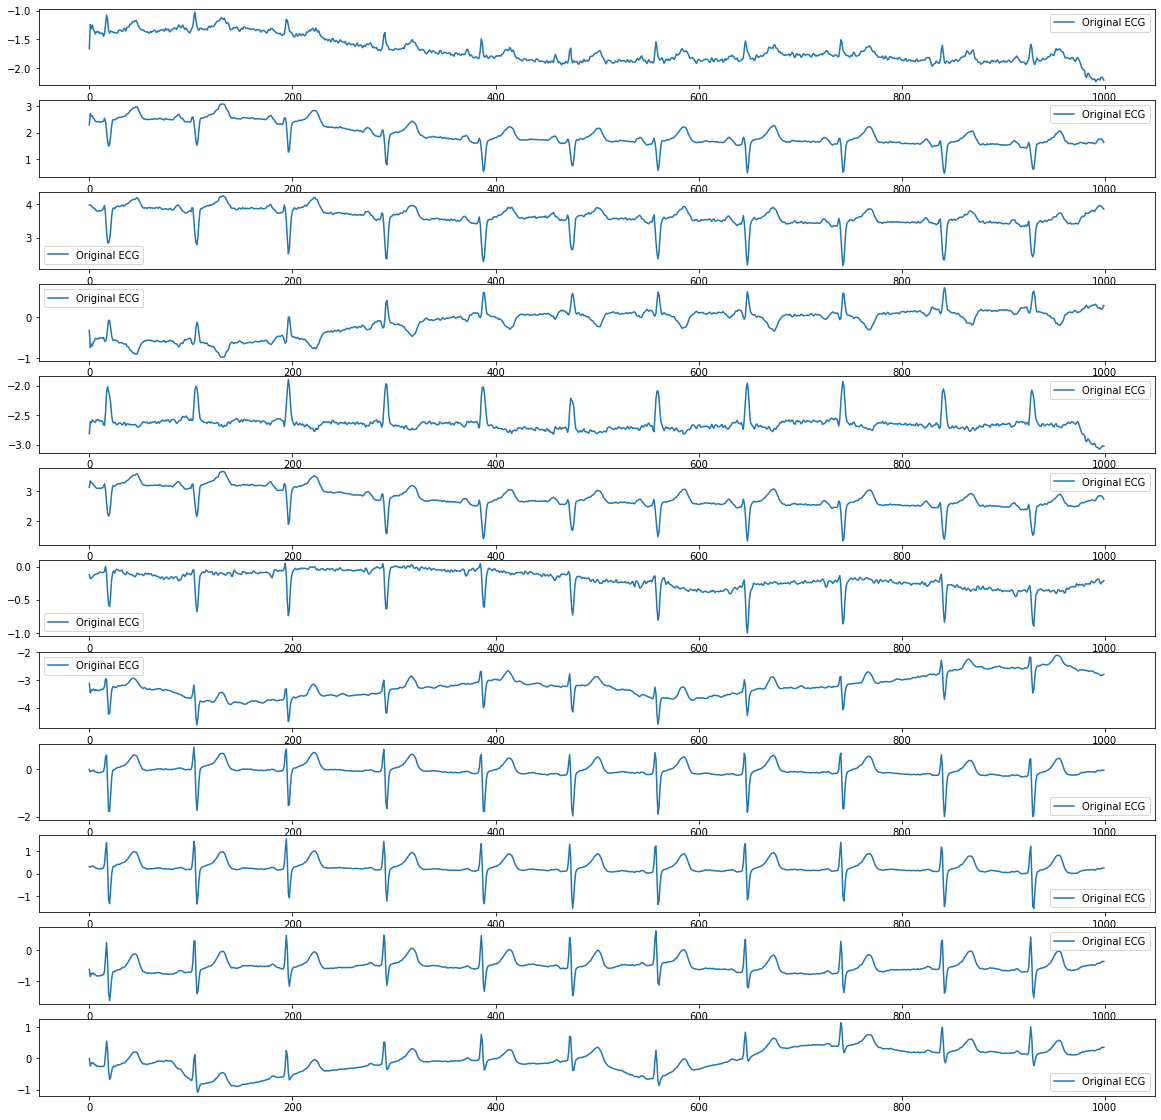

In [11]:
plt.figure(figsize=(20,20))
for i in range(12):
    plt.subplot(12,1,i+1)
    plt.plot(np.asarray(ecg_pad)[:,i], label= "Original ECG")
    plt.legend()

In [12]:
def optimize_linear(grad, eps):
    """
    Solves for the optimal input to a linear function under a norm constraint.

    Optimal_perturbation = argmax_{eta, ||eta||_{norm} < eps} dot(eta, grad)

    :param grad: tf tensor containing a batch of gradients
    :param eps: float scalar specifying size of constraint region
    :param norm: int specifying order of norm
    :returns:
      tf tensor containing optimal perturbation
    """

    # Convert the iterator returned by `range` into a list.
    axis = list(range(1, len(grad.get_shape())))
    avoid_zero_div = 1e-12

    # Take sign of gradient
    optimal_perturbation = tf.sign(grad)
    # The following line should not change the numerical results. It applies only because
    # `optimal_perturbation` is the output of a `sign` op, which has zero derivative anyway.
    # It should not be applied for the other norms, where the perturbation has a non-zero derivative.
    optimal_perturbation = tf.stop_gradient(optimal_perturbation)
    
    # Scale perturbation to be the solution for the norm=eps rather than norm=1 problem
    scaled_perturbation = tf.multiply(eps, optimal_perturbation)
    return scaled_perturbation

In [13]:
from scipy.ndimage import uniform_filter

In [14]:
from scipy.signal import butter, filtfilt
def bandpass_filter(signal, lowcut=0.5, highcut=50, fs=500, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)


In [15]:
num_epochs = 100
eps = 0.01
data_example = np.expand_dims(ecg_pad,0)
pred_example = y_data
desired_pred = np.array([[1]])

data_example = tf.convert_to_tensor(data_example, dtype=tf.float32)

adv_x = data_example

while model.predict(adv_x)[0][0] < 0.01:
    print(model.predict(adv_x))
    with tf.GradientTape() as tape:
      tape.watch(adv_x)
      pred = model(adv_x)
      loss = tf.keras.losses.binary_crossentropy(desired_pred, pred)
      loss = -loss
      #print(np.asarray(loss))
    grads = tape.gradient(loss, adv_x)
    #print(grads)
    optimal_perturbation = optimize_linear(grads, eps)
    #optimal_perturbation = uniform_filter(optimal_perturbation[0], 15, mode='constant')
    print(optimal_perturbation.shape)
    optimal_perturbation_filtered = np.array([bandpass_filter(optimal_perturbation[0,:,i], fs=fs) for i in range(12)])
    optimal_perturbation_filtered = np.expand_dims(np.moveaxis(optimal_perturbation_filtered,0,-1),0)
    #print(optimal_perturbation)
    # Add perturbation to original example to obtain adversarial example
    adv_x = adv_x + optimal_perturbation_filtered

    adv_x = tf.convert_to_tensor(adv_x)
    # Ensure plausible values (might be something else than -2 to 5)
    #adv_x = tf.clip_by_value(adv_x, -2,5)

    #opt.apply_gradients(zip(grads, model.trainable_variables))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[[0.00045722]]
(1, 1000, 12)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[[0.00047423]]
(1, 1000, 12)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
[[0.00048993]]
(1, 1000, 12)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[0.00050499]]
(1, 1000, 12)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[[0.0005195]]
(1, 1000, 12)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
[[0.0005339]]
(1, 1000, 12)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[[0.00054825]]
(1, 1000, 12)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
[[0.00056253]]
(1, 1000, 12)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
[[0.00057693]]
(1, 1000, 12)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━

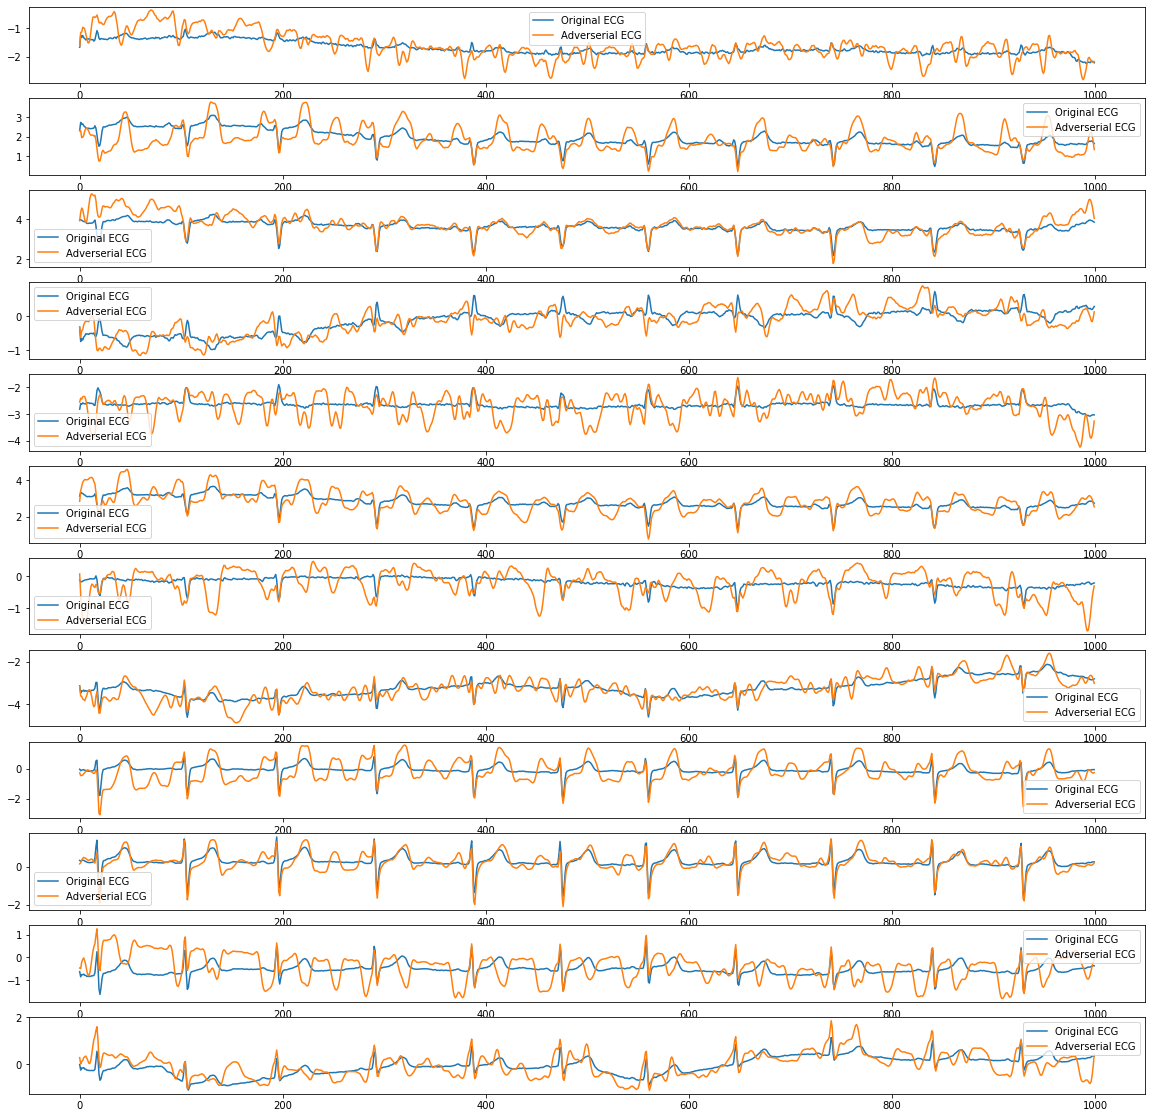

In [16]:
plt.figure(figsize=(20,20))
#adv_x = bandpass_filter(adv_x)
for i in range(12):
    plt.subplot(12,1,i+1)
    plt.plot(np.asarray(data_example)[0,:,i], label= "Original ECG")
    plt.plot(np.asarray(adv_x)[0,:,i], label= "Adverserial ECG")
    plt.legend()

In [17]:
num_epochs = 100
eps = 0.1
data_example = np.expand_dims(ecg_pad,0)
pred_example = y_data
desired_pred = np.array([[1]])

data_example = tf.convert_to_tensor(data_example, dtype=tf.float32)

adv_x = data_example

while model.predict(adv_x)[0][0] < 0.01:
    print(model.predict(adv_x))
    with tf.GradientTape() as tape:
      tape.watch(adv_x)
      pred = model(adv_x)
      loss = tf.keras.losses.binary_crossentropy(desired_pred, pred)
      loss = -loss
      #print(np.asarray(loss))
    grads = tape.gradient(loss, adv_x)
    #print(grads)
    optimal_perturbation = optimize_linear(grads, eps)
    optimal_perturbation_filtered = uniform_filter(optimal_perturbation[0], 15, mode='constant')
    #print(optimal_perturbation.shape)
    #optimal_perturbation_filtered = np.array([bandpass_filter(optimal_perturbation[0,:,i], fs=fs) for i in range(12)])
    #optimal_perturbation_filtered = np.expand_dims(np.moveaxis(optimal_perturbation_filtered,0,-1),0)
    #print(optimal_perturbation)
    # Add perturbation to original example to obtain adversarial example
    adv_x = adv_x + optimal_perturbation_filtered

    adv_x = tf.convert_to_tensor(adv_x)
    # Ensure plausible values (might be something else than -6 to +6)
    adv_x = tf.clip_by_value(adv_x, -6,6)

    #opt.apply_gradients(zip(grads, model.trainable_variables))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
[[0.00045722]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
[[0.00051473]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[[0.00056495]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
[[0.00060612]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
[[0.00063864]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
[[0.0006632]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
[[0.00068208]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
[[0.00069861]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
[[0.00071358]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
[[0.00072834]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
[[0.00074325]]


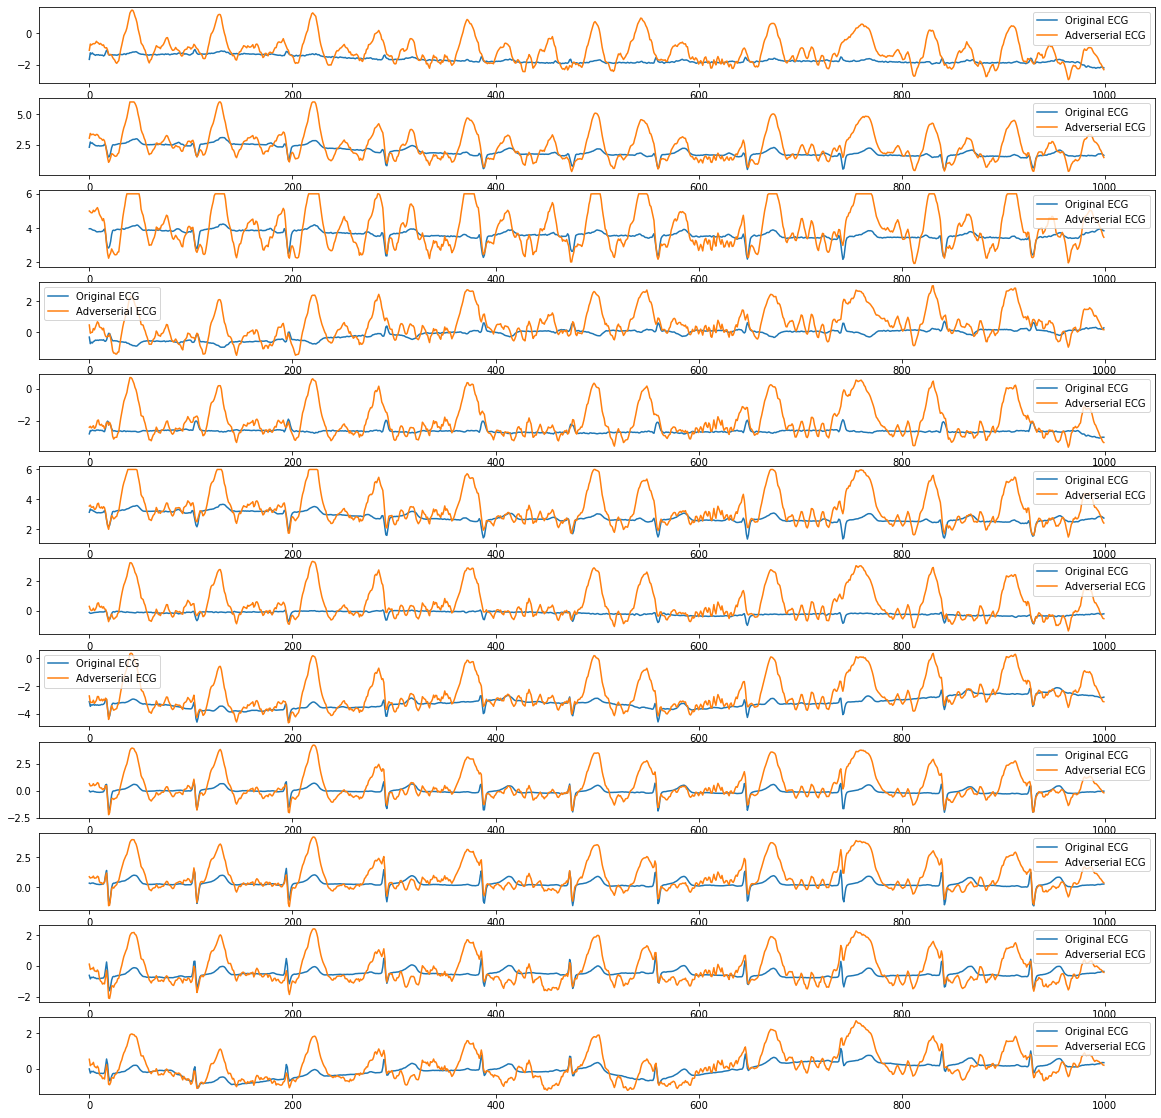

In [18]:
plt.figure(figsize=(20,20))
#adv_x = bandpass_filter(adv_x)
for i in range(12):
    plt.subplot(12,1,i+1)
    plt.plot(np.asarray(data_example)[0,:,i], label= "Original ECG")
    plt.plot(np.asarray(adv_x)[0,:,i], label= "Adverserial ECG")
    plt.legend()